In [304]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS


from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from collections import Counter

import matplotlib.pyplot as plt
% matplotlib inline

In [112]:
ps = nltk.PorterStemmer()
en_stop = set(stopwords.words('english'))

In [2]:
NAME_BREAKUP_RE = re.compile(r"[^a-zA-Z]+")

def extract_names(token):
	token = token.strip()
	prev_p = [""]

	def ret(name):
		r = name.lower()
		if len(name) >= 3:
			yield r
			if prev_p[0]:
				yield prev_p[0] + r
				prev_p[0] = ""
		else:
			prev_p[0] = r

	for part in NAME_BREAKUP_RE.split(token):
		if not part:
			continue
		prev = part[0]
		pos = 0
		for i in range(1, len(part)):
			this = part[i]
			if prev.islower() and this.isupper():
				yield from ret(part[pos:i])
				pos = i
			elif prev.isupper() and this.islower():
				if 0 < i - 1 - pos <= 3:
					yield from ret(part[pos:i - 1])
					pos = i - 1
				elif i - 1 > pos:
					yield from ret(part[pos:i])
					pos = i
			prev = this
		last = part[pos:]
		if last:
			yield from ret(last)

In [3]:
sourcecode = pd.read_csv("source_code_identifier_names", sep='\t', header=None)
#sourcecode = sourcecode.drop(index=[3, 10]).reset_index()
#sourcecode.drop(columns=['index'])
sourcecode

,0,1,2
0,google/web-starter-kit,mdl demo mdl layout header row mdl demo mdl la...,copyright google inc all rights reserved licen...
1,JacksonTian/fks,node fill stroke stroke width node node hover ...,dendrogram tooltip doctype html update the too...
2,nfl/react-helmet,module exports config normalization browser na...,karma configuration normal karma configuration...
3,domnikl/DesignPatternsPHP,sphinxopts sphinxbuild paper builddir error th...,makefile for sphinx documentation you can set ...
4,petkaantonov/bluebird,mocha helvetica arial mocha mocha mocha mocha ...,approximate for browsers not supporting calc p...
5,eslint/eslint,arial helvetica overview calc clr clr after la...,doctype html doctype html test framework sourc...
6,vuejs/vuex,require path require zlib require uglify requi...,eslint disable camelcase eslint enable camelca...
7,wekan/wekan,activity title space between activities activi...,from https github com tobiasahlin spin kit usa...
8,VerbalExpressions/JSVerbalExpressions,module exports grunt config grunt grunt init c...,file verbal expressions java script library ve...
9,yangyangwithgnu/hardseed,project set set set set add executable src lis...,linux debug set cmake cxx compiler clang set c...


In [4]:
sourcecode.shape

(2581, 3)

In [5]:
sourcecode.columns = ['repo', 'token.name', 'token.comment']

In [6]:
data = sourcecode

In [7]:
#data = data.dropna(subset=['token.name'])
data.fillna({'token.name': ' ', 'token.comment': ' '}, inplace=True)

In [8]:
data.shape

(2581, 3)

In [9]:
data.head()

,repo,token.name,token.comment
0,google/web-starter-kit,mdl demo mdl layout header row mdl demo mdl la...,copyright google inc all rights reserved licen...
1,JacksonTian/fks,node fill stroke stroke width node node hover ...,dendrogram tooltip doctype html update the too...
2,nfl/react-helmet,module exports config normalization browser na...,karma configuration normal karma configuration...
3,domnikl/DesignPatternsPHP,sphinxopts sphinxbuild paper builddir error th...,makefile for sphinx documentation you can set ...
4,petkaantonov/bluebird,mocha helvetica arial mocha mocha mocha mocha ...,approximate for browsers not supporting calc p...


In [115]:
# Count the number of words and the number of distinct words in each document
def doc_length(document):
    return len(document.split(' '))
def countdistinct(document):
    return len(set(document.split(' ')))
# Stem text
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text.split(' ') if word not in en_stop]
    res = " ".join(text)
    return res

In [138]:
def preprocess_data(doc):
    """
    Input  : docuemnt text
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # clean and tokenize document string

    tokens = tokenizer.tokenize(doc)
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

    return " ".join(stemmed_tokens) 

In [238]:
sample = pd.read_csv("test_identifier_names", sep='\t', header=None)
sample.columns = ['repo', 'token.name', 'token.comment']

In [250]:
sample

,repo,token.name,token.comment,tag,tn_length,tc_length,tn_difflen,tc_difflen
0,mhoofman/wordpress-heroku,about wrap about wrap updated about wrap error...,about pages global about credits freedoms typo...,0,482267,159686,7003,13853
1,dxw/wordpress,about wrap about wrap updated about wrap error...,about pages global about credits freedoms typo...,0,483376,163361,6935,13928
2,jumilla/wordpress-plus,about wrap about wrap updated about wrap error...,theme name theme name theme uri theme uri vers...,0,503210,165061,7129,14224
3,markjaquith/WordPress,about wrap about wrap full width layout about ...,about pages global about credits freedoms typo...,0,882888,305525,9123,19314
4,twitter/mysql,begin curr mcurr count mcount level mlevel cur...,copyright sql mysql use subject issubject lice...,1,861375,833065,11140,31236
5,facebook/mysql-5.6,results results results results results result...,bin awk the ifthe output format has changed an...,1,1132662,1032194,13520,35269
6,Tokutek/mysql-5.5,begin curr mcurr count mcount level mlevel cur...,copyright sql mysql use subject issubject lice...,1,853522,822965,11052,31074
7,Tokutek/mariadb-5.5,begin curr mcurr count mcount level mlevel cur...,copyright sql mysql use subject issubject lice...,1,1453540,1336241,12143,34674
10,ChimeraCoder/gitgo,usage str main argc argv stat from buf data bu...,test delta test ctest code exercise toexercise...,2,5092,2317,294,791
11,src-d/go-git,main main check args url directory args args i...,example anexample how ofhow create tocreate an...,2,117216,47893,1689,5761


In [247]:
tag = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3])
sample['tag'] = tag

In [252]:
sample['stemmed_name'] = sample['token.name'].map(preprocess_data)
sample['stemmed_comment'] = sample['token.comment'].map(preprocess_data)

In [299]:
sample['tn_length'] = sample['stemmed_name'].map(doc_length)
sample['tc_length'] = sample['stemmed_comment'].map(doc_length)
sample['tn_difflen'] = sample['stemmed_name'].map(countdistinct)
sample['tc_difflen'] = sample['stemmed_comment'].map(countdistinct)

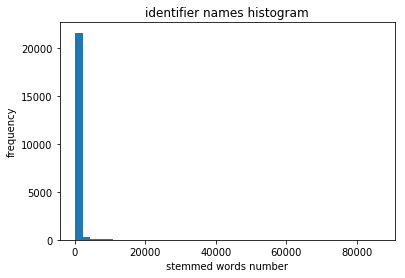

In [336]:
# the histogram of the data
sample_name_text = " ".join([doc for doc in sample['stemmed_name']])
sample_name_count = Counter(sample_name_text.split(' '))
sample_name_count = [s[1] for s in sample_name_count.most_common()]
n, bins, patches = plt.hist(sample_name_count, 40)

plt.xlabel('stemmed words number')
plt.ylabel('frequency')
plt.title('identifier names histogram')
plt.show()

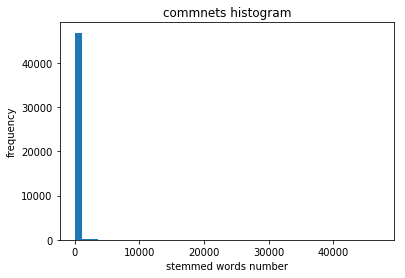

In [338]:
sample_comment_text = " ".join([doc for doc in sample['stemmed_comment']])
sample_comment_count = Counter(sample_comment_text.split(' '))
sample_comment_count = [s[1] for s in sample_comment_count.most_common()]
n, bins, patches = plt.hist(sample_comment_count, 40)

plt.xlabel('stemmed words number')
plt.ylabel('frequency')
plt.title('commnets histogram')
plt.show()

### Tf-Idf Matrix

In [253]:
sample_tfidf_vect = TfidfVectorizer(stop_words='english', 
#max_features= 20000, # keep top 20000 terms 
max_df = 0.85, 
min_df = 2,
smooth_idf=True)
sample_X = sample_tfidf_vect.fit_transform(sample['stemmed_name'])

In [260]:
dist = 1 - cosine_similarity(sample_X)

### K-means

In [254]:
num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(sample_X)

clusters = km.labels_.tolist()

CPU times: user 3.03 s, sys: 288 ms, total: 3.31 s
Wall time: 1.87 s


In [255]:
clusters

[1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 0, 0]

In [286]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {0: 'torch', 
                 1: 'wordpress', 
                 2: 'go-git', 
                 3: 'database'}

In [283]:
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [284]:
visKmeans_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=sample['repo']))

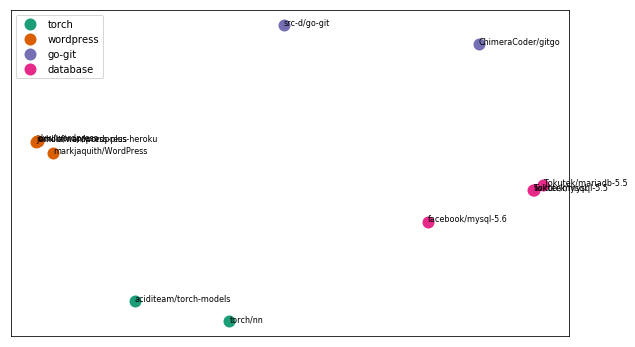

In [292]:
#group by cluster
groups = visKmeans_df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(10, 6)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(visKmeans_df)):
    ax.text(visKmeans_df.iloc[i]['x'], visKmeans_df.iloc[i]['y'], visKmeans_df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

### LDA

In [297]:
sample_cv = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
sample_dtm = sample_cv.fit_transform(sample['stemmed_name'])
sample_LDA = LatentDirichletAllocation(n_components=4,random_state=42)
sample_LDA.fit(sample_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [298]:
for index,topic in enumerate(sample_LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([sample_cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['dbug', 'univ', 'uint', 'mutex', 'field', 'stmt', 'trx', 'mtr', 'ulint', 'lock', 'uchar', 'block', 'rec', 'page', 'mysql']


THE TOP 15 WORDS FOR TOPIC #1
['linear', 'resiz', 'plane', 'real', 'batch', 'bia', 'paramet', 'mytest', 'dim', 'model', 'torch', 'weight', 'tensor', 'grad', 'self']


THE TOP 15 WORDS FOR TOPIC #2
['media', 'titl', 'filter', 'array', 'link', 'isset', 'theme', 'user', 'widget', 'content', 'item', 'url', 'comment', 'menu', 'post']


THE TOP 15 WORDS FOR TOPIC #3
['content', 'decod', 'tag', 'request', 'session', 'cmd', 'pack', 'refer', 'req', 'commit', 'tree', 'oper', 'statu', 'suit', 'nil']




In [ ]:
data['tn_length'] = data['token.name'].map(doc_length)
data['tc_length'] = data['token.comment'].map(doc_length)
data['tn_difflen'] = data['token.name'].map(countdistinct)
data['tc_difflen'] = data['token.comment'].map(countdistinct)

In [74]:
# filter those with distinct words less than 50
sub_data = data[data['tn_difflen'] > 50]
# filter those with more than 1000000 identifier names
sub_data = sub_data[sub_data['tn_length'] < 1000000]

##### Extract stem from each repository. This would take an hour and a half

In [ ]:
sub_data['stemmed_name'] = sub_data['token.name'].map()
sub_data['stemmed_comment'] = sub_data['token.comment'].map(stemming)

In [159]:
sub_data['stemmed_name'] = sub_data['token.name'].map(preprocess_data)
sub_data['stemmed_comment'] = sub_data['token.comment'].map(preprocess_data)

In [160]:
sub_data['tn_length'] = sub_data['stemmed_name'].map(doc_length)
sub_data['tc_length'] = sub_data['stemmed_comment'].map(doc_length)
sub_data['tn_difflen'] = sub_data['stemmed_name'].map(countdistinct)
sub_data['tc_difflen'] = sub_data['stemmed_comment'].map(countdistinct)

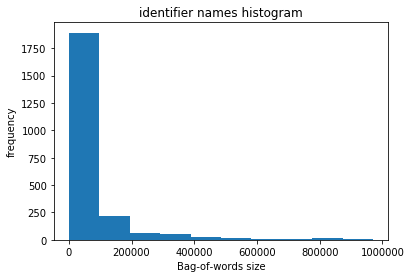

In [308]:
# the histogram of the data
n, bins, patches = plt.hist(sub_data['tn_length'])

plt.xlabel('Bag-of-words size')
plt.ylabel('frequency')
plt.title('identifier names histogram')
plt.show()

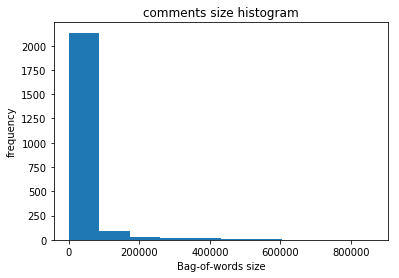

In [309]:
# the histogram of the data
n, bins, patches = plt.hist(sub_data['tc_length'])

plt.xlabel('Bag-of-words size')
plt.ylabel('frequency')
plt.title('comments size histogram')
plt.show()

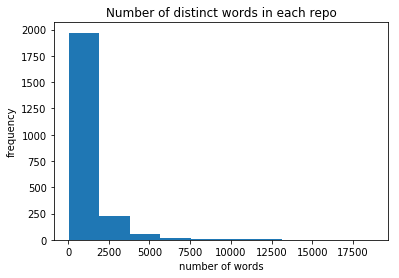

In [307]:
n, bins, patches = plt.hist(sub_data['tn_difflen'])

plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Number of distinct words in each repo')
plt.show()

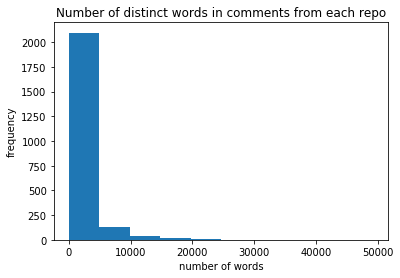

In [311]:
n, bins, patches = plt.hist(sub_data['tc_difflen'])

plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Number of distinct words in comments from each repo')
plt.show()

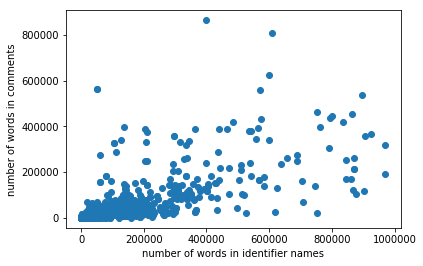

In [350]:
plt.scatter(sub_data['tn_length'], sub_data['tc_length'])
plt.xlabel('number of words in identifier names')
plt.ylabel('number of words in comments')
plt.show()

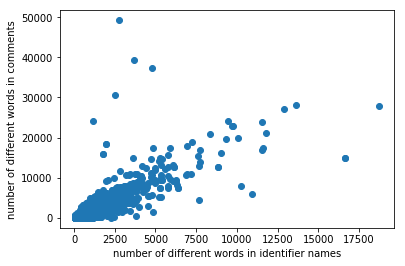

In [351]:
plt.scatter(sub_data['tn_difflen'], sub_data['tc_difflen'])
plt.xlabel('number of different words in identifier names')
plt.ylabel('number of different words in comments')
plt.show()

In [339]:
total_text = " ".join([doc for doc in sub_data['stemmed_name']])
total_comment = " ".join([com for com in sub_data['stemmed_comment']])
text_count = Counter(total_text.split(' ')).most_common()
comment_count = Counter(total_comment.split(' ')).most_common()

In [340]:
text_count = [tc[1] for tc in text_count]
comment_count = [cc[1] for cc in comment_count]

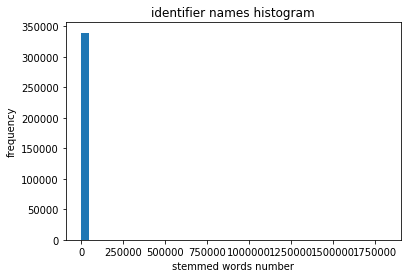

In [346]:
n, bins, patches = plt.hist(text_count, 40)

plt.xlabel('stemmed words number')
plt.ylabel('frequency')
plt.title('identifier names histogram')
plt.show()

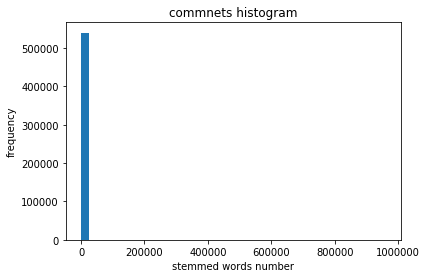

In [347]:
n, bins, patches = plt.hist(comment_count, 40)

plt.xlabel('stemmed words number')
plt.ylabel('frequency')
plt.title('commnets histogram')
plt.show()

In [171]:
sub_data.to_csv(r'stemmed_data.csv')

In [161]:
tn_data = sub_data[['repo', 'stemmed_name', 'tn_length', 'tn_difflen']]

In [87]:
tn_data['tn_length'].describe()

count      2294.000000
mean      65444.633391
std      130372.029170
min          99.000000
25%        4248.000000
50%       17158.500000
75%       60741.750000
max      985772.000000
Name: tn_length, dtype: float64

In [88]:
tn_data['tn_difflen'].describe()

count     2294.000000
mean      1120.127724
std       1523.129682
min         47.000000
25%        313.000000
50%        658.500000
75%       1330.000000
max      18797.000000
Name: tn_difflen, dtype: float64

In [89]:
total_text = " ".join([doc for doc in tn_data['stemmed_name']])

In [90]:
len(total_text.split(' '))

150129989

In [91]:
len(set(total_text.split(' ')))

339891

### Vectorize documents

### Embedding each repo by word count

**max_df**:  ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**min_df**:  ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**max_features** : int or None (default=None)
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [230]:
cv = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')
dtm = cv.fit_transform(tn_data['stemmed_name'])

In [231]:
dtm.shape

(2294, 152989)

In [163]:
word_count = pd.DataFrame(dtm.toarray())
word_count.columns = cv.get_feature_names()

In [110]:
word_count.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaansu,aaaar,aaae,aab,aabb,...,zym,zyn,zyx,zz,zzc,zzr,zzuf,zzv,zzz,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(word_count)


In [224]:
tfidf_vect = TfidfVectorizer(stop_words='english', 
#max_features= 20000, # keep top 20000 terms 
max_df = 0.85, 
min_df = 2,
smooth_idf=True)
X = tfidf_vect.fit_transform(tn_data['stemmed_name'])

##### k-means clustering

In [183]:
num_clusters = 20

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf)

clusters = km.labels_.tolist()

CPU times: user 8min 4s, sys: 8.93 s, total: 8min 12s
Wall time: 8min 2s


##### Topic modeling using LSA

In [225]:
svd_model = TruncatedSVD(n_components=30, algorithm='randomized', n_iter=1000, random_state=122)
svd_model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=30, n_iter=1000,
       random_state=122, tol=0.0)

In [226]:
terms = tfidf_vect.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]
    print("Topic "+str(i)+": ")
    print(" ".join([t[0] for t in sorted_terms]))

Topic 0: 
self assert err expect node option equal config prop event requir state url result item element arg request length list
Topic 1: 
self true fals kwarg dict train sy isinst len loss pytest shape django model cl batch init dtype tensor help
Topic 2: 
err assert errorf fmt http new req request server client log conn config fatalf ctx byte len respons servic cmd
Topic 3: 
assert equal expect strict qunit describ requir foo deep promis xct result obj toequal node object element array jqueri method
Topic 4: 
view assert android com anim java layout imag overrid color org activ event list util item size intent control text
Topic 5: 
node err element assert len length index line num style child left size tree fmt width equal rang layer document
Topic 6: 
prop assert err react style equal state self compon view icon render store div theme color wrapper errorf action anim
Topic 7: 
expect view toequal node android err spi describ anim jasmin equal context com layout observ tohav self l

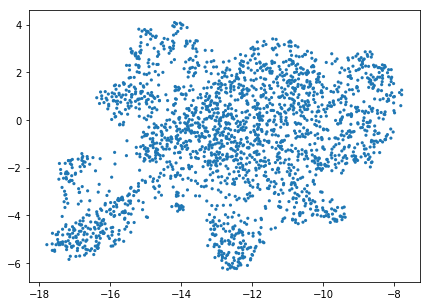

In [227]:
import umap.umap_ as umap
X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
#c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

#### LSI Method

In [164]:
def get_doc_list(doc_col):
    texts = []
    for doc in doc_col:
        tokens = tokenizer.tokenize(doc)
        texts.append(tokens)
    return texts

In [165]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [166]:
# Create LSA model

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [167]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [168]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [169]:
clean_text = get_doc_list(tn_data['stemmed_name'])

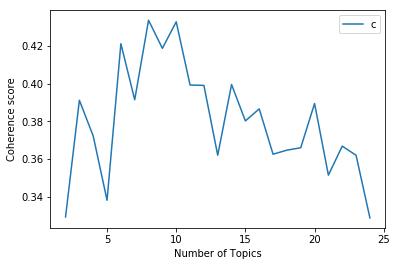

In [170]:
start,stop,step=2,25,1
plot_graph(clean_text,start,stop,step)
